In [1]:
from Datapreparation import *
from satellite_eda import *
from models import *
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import math
import ruptures as rpt
import pandas as pd
from sklearn.preprocessing import StandardScaler

Loading dataset SARAL Ready.


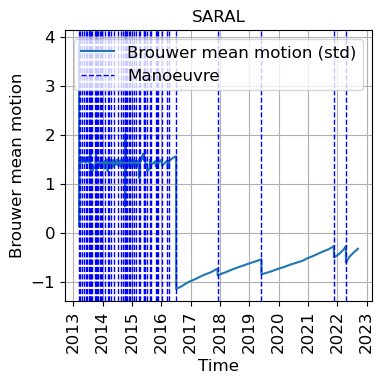

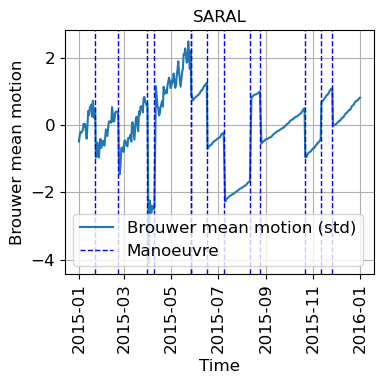

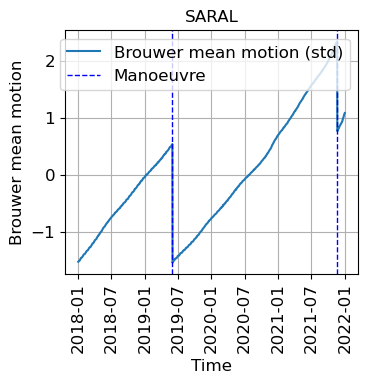

In [2]:
SRL = Satellite("./orbital_elements/SARAL.csv", "./manoeuvres/srlman.txt")
eda = SatelliteEDA(SRL)
eda.col_with_man()
eda.col_with_man(start_date="2015-01-01", end_date = "2016-01-01")
eda.col_with_man(start_date="2018-01-01", end_date = "2022-01-01")

# Segmented Modelling

In [3]:
def find_breaks(satellite, pen):  
    series = satellite.df_orbit['Brouwer mean motion']
    
    signal_std = StandardScaler().fit_transform(series.values.reshape(-1, 1)).flatten()
    model = rpt.Pelt(model="l2").fit(signal_std)
    breaks = model.predict(pen)
    
    break_times = SRL.df_orbit['Brouwer mean motion'].index[breaks[:-1]].tolist()
    return break_times

def optimized_search(satellite, arima_grid, xgb_grid, buffer=3):
    arima = ARIMAModel(satellite)
    arima.grid_search(arima_grid, buffer)
    print("ARIMA best params:", arima.best_params, "pr_auc:", arima.eval_results['pr_auc'])

    xgb = XGBoostModel(satellite, brouwer_only=True)
    xgb.grid_search(xgb_grid, buffer)
    print("XGB best params:", xgb.best_params, "pr_auc:", xgb.eval_results['pr_auc'])

    return arima, xgb

def segment_optimized_search(satellite, break_times, arima_grid, xgb_grid, buffer=3):
    all_times = [satellite.df_orbit.index.min()] + break_times + [satellite.df_orbit.index.max()]
    segment_results = []
    arima_zscores = []
    xgb_zscores = []

    for i in range(len(all_times) - 1):
        start, end = all_times[i], all_times[i + 1]
        sub_sat = satellite.copy_range(start, end)
        print(f"\n Segment {i+1}: {start.date()} ~ {end.date()}")

        arima, xgb = optimized_search(sub_sat, arima_grid, xgb_grid, buffer=buffer)

        # Save models
        segment_results.append({
            "range": (start, end),
            "arima": arima,
            "xgb": xgb
        })

        # Perform z-score normalization on residuals of each segment, then concatenate
        z_arima = StandardScaler().fit_transform(arima.residuals.to_frame()).flatten()
        z_arima_series = pd.Series(z_arima, index=arima.residuals.index)
        arima_zscores.append(z_arima_series)

        z_xgb = StandardScaler().fit_transform(xgb.residuals.to_frame()).flatten()
        z_xgb_series = pd.Series(z_xgb, index=xgb.residuals.index)
        xgb_zscores.append(z_xgb_series)

    # Concatenate globally normalized residuals
    arima_all = pd.concat(arima_zscores).sort_index()
    xgb_all   = pd.concat(xgb_zscores).sort_index()

    return segment_results, arima_all, xgb_all

def plot_segment_models_with_global(segment_results, arima_all, xgb_all, satellite, buffers):
    num_segments = len(segment_results)
    total_plots = num_segments + 1  # add one for global
    cols = 2
    rows = math.ceil(total_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), squeeze=False)
    axes = axes.flatten()

    # Plot segment-wise PR curves
    for i, result in enumerate(segment_results):
        ax = axes[i]
        for buffer in buffers:
            result["arima"].evaluate(buffer)
            res_arima = result["arima"].eval_results
            ax.plot(res_arima["recalls"], res_arima["precisions"],
                    label=f"ARIMA (buffer={buffer})")

            result["xgb"].evaluate(buffer)
            res_xgb = result["xgb"].eval_results
            ax.plot(res_xgb["recalls"], res_xgb["precisions"],
                    label=f"XGB (buffer={buffer})")

        start, end = result["range"]
        ax.set_title(f"Segment {i+1}: {start.date()} to {end.date()}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()
        ax.grid(True)

    # Plot global model performance
    ax = axes[num_segments]
    for buffer in buffers:
        global_arima_eval = evaluate_global_precision_recall(arima_all, satellite, buffer)
        ax.plot(global_arima_eval["recalls"], global_arima_eval["precisions"],
                linestyle="--", label=f"ARIMA Global (buffer={buffer}, AUC={global_arima_eval['pr_auc']:.3f})")

        global_xgb_eval = evaluate_global_precision_recall(xgb_all, satellite, buffer)
        ax.plot(global_xgb_eval["recalls"], global_xgb_eval["precisions"],
                linestyle="--", label=f"XGB Global (buffer={buffer}, AUC={global_xgb_eval['pr_auc']:.3f})")

    ax.set_title("Global Model Performance")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    ax.grid(True)

    # Hide unused axes
    for j in range(total_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [4]:
arima_grid = {'p': [0,1,2], 'q': [0,1,2], 'd': [0,1]}

xgb_grid   = {
    'n_lags':     [90, 180, 360],
    'n_estimators':[10, 20],
    'max_depth':  [5, 10],
    'colsample_bytree': [0.5, 0.7],
    'learning_rate': [0.01, 0.05, 0.1]
}

buffers = [1,2,3]  # days

In [5]:
break_times = find_breaks(SRL, 50)

segment_results, arima_all, xgb_all = segment_optimized_search(
    SRL, break_times,
    arima_grid=arima_grid,
    xgb_grid=xgb_grid,
    buffer=3
)


 Segment 1: 2013-03-10 ~ 2016-07-05
ARIMA best params: {'p': 1, 'q': 0, 'd': 0} pr_auc: 0.35081675560777104
XGB best params: {'n_lags': 90, 'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7} pr_auc: 0.6038986843759119

 Segment 2: 2016-07-05 ~ 2020-07-31
ARIMA best params: {'p': 0, 'q': 2, 'd': 0} pr_auc: 0.29166666402777774
XGB best params: {'n_lags': 360, 'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5} pr_auc: 0.49999999375000004

 Segment 3: 2020-07-31 ~ 2022-09-14
ARIMA best params: {'p': 0, 'q': 0, 'd': 0} pr_auc: 0.49999999375000004
XGB best params: {'n_lags': 90, 'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.5} pr_auc: 0.49999999375000004


In [6]:
def plot_segment_models_with_global_segment3_only(segment_results, arima_all, xgb_all, satellite, buffers):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))

    i = 0
    result = segment_results[i]
    for buffer in buffers:
        result["arima"].evaluate(buffer)
        res_arima = result["arima"].eval_results
        plt.plot(res_arima["recalls"], res_arima["precisions"],
                 label=f"ARIMA (buffer={buffer})")

        result["xgb"].evaluate(buffer)
        res_xgb = result["xgb"].eval_results
        plt.plot(res_xgb["recalls"], res_xgb["precisions"],
                 label=f"XGB (buffer={buffer})")

    plt.title("SARAL Precision–Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

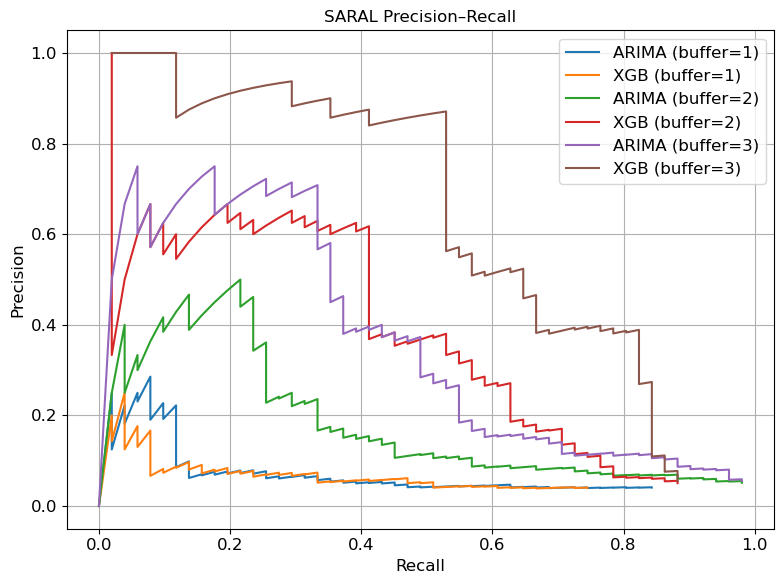

In [7]:
plot_segment_models_with_global_segment3_only(segment_results, arima_all, xgb_all, SRL, buffers=[1, 2, 3])